# Status update: 

### Changes made for this notebook:
- Adaptive learning rate implemented
- Validation loss is outputted along with training loss
- Training loop within training loop somehow produces better results

### Suggestions for future: 
- Split data into training, validation, and testing datasets

# Load data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset


# Training/Testing Dataset Loading (already created)

In [2]:
ds_training = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic_every10TimeSteps.zarr", engine="zarr", chunks={}
) 
ds_training

<xarray.Dataset> Size: 36MB
Dimensions:   (time: 28, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 224B 0181-01-01 12:00:00 ... 0181-09-28 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 3MB dask.array<chunksize=(14, 82, 75), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 5MB dask.array<chunksize=(7, 82, 75), meta=np.ndarray>

In [3]:
ds_testing = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_testingData_southAtlantic_every10TimeSteps.zarr", engine="zarr", chunks={}
) 
ds_testing

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-10-08 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB dask.array<chunksize=(5, 82, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>

#### Convert to torch tensor

In [4]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_training['u_rel'].values
v_rel = ds_training['v_rel'].values
t_ref = ds_training['t_ref'].values
q_ref = ds_training['q_ref'].values
sst = ds_training['sst'].values
Q_out = ds_training['Q_out'].values #Q_LR
Q_star = ds_training['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs.shape


torch.Size([28, 163, 150, 7])

In [5]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_testing['u_rel'].values
v_rel = ds_testing['v_rel'].values
t_ref = ds_testing['t_ref'].values
q_ref = ds_testing['q_ref'].values
sst = ds_testing['sst'].values
Q_out = ds_testing['Q_out'].values
Q_star = ds_testing['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs.shape


torch.Size([9, 163, 150, 7])

## NN architecture setup

In [6]:
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)  # Adjust input channels to 6
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_height // 8) * (image_width // 8), 128)  # Adjust for image dimensions = bring to correct dimension for pooling input size
        self.fc2 = nn.Linear(128, output_channels * image_height * image_width)  # Adjust output shape

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, output_channels, image_height, image_width)  # Reshape to output image
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)


In [8]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

In [9]:
class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step
        
        # Assuming the shape is (x, y, vars), we need to split the last dimension
        # Let's say vars=6, then we extract the input images
        input_images = data[:, :, :6]  # Take the first 6 variables (assuming they are the images)

        # Load the corresponding target, assuming it's the next variable (var 7)
        target = data[:, :, 6]  # Replace with your actual target variable index

        return input_images, target  # Return input (6 images) and target


In [10]:
# Training dataset into DataLoader
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

# Testing dataset into DataLoader
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

In [11]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


In [12]:
num_epochs = 50  # Number of epochs to train
num_runs = 5

In [13]:
all_loss_values = []
all_val_loss_values = []

for run in range(num_runs):

    loss_values = []
    val_loss_values = []

    # reset optimizer for each loop
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for inputs, targets in train_loader:
            # inputs shape: [1, y, x, variables (6)]
            # targets shape: [1, y, x]

            # Note: Squeeze and unsqueeze to make model more generalizable (can skip if dims are exact)
        
            # Squeeze batch dimension (since batch_size=1)
            inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
            targets = targets.squeeze(0)  # Shape: (y, x)

            # Convert inputs to float32
            inputs = inputs.float()
            targets = targets.float()

            # Zero/reset the parameter gradients before next iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
            targets = targets.unsqueeze(0)  # Add batch dimension to targets

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()
    
        # Calculate average loss for the epoch
        average_loss = running_loss / len(train_loader)
        loss_values.append(average_loss)
        all_loss_values.append(average_loss)

        # ---- Validation Phase ----
        # Call evaluate_model function to get validation loss
        average_val_loss, _, _ = evaluate_model(model, test_loader, criterion)
        val_loss_values.append(average_val_loss)
        all_val_loss_values.append(average_val_loss)

        # Step the scheduler with the validation loss
        scheduler.step(average_loss)
    
        # Print epoch statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

    print(f"Training complete for Run {run}")

Epoch [1/50], Training Loss: 40.5588, Validation Loss: 19.5121
Epoch [2/50], Training Loss: 37.8195, Validation Loss: 19.4826
Epoch [3/50], Training Loss: 37.7651, Validation Loss: 19.4642
Epoch [4/50], Training Loss: 37.7221, Validation Loss: 19.4484
Epoch [5/50], Training Loss: 37.6909, Validation Loss: 19.4340
Epoch [6/50], Training Loss: 35.8319, Validation Loss: 16.3981
Epoch [7/50], Training Loss: 27.4523, Validation Loss: 19.3695
Epoch [8/50], Training Loss: 22.9454, Validation Loss: 17.7211
Epoch [9/50], Training Loss: 22.3287, Validation Loss: 19.5925
Epoch [10/50], Training Loss: 23.7714, Validation Loss: 21.6721
Epoch [11/50], Training Loss: 23.4753, Validation Loss: 16.4184
Epoch [12/50], Training Loss: 25.3775, Validation Loss: 34.1728
Epoch [13/50], Training Loss: 22.5361, Validation Loss: 17.4315
Epoch [14/50], Training Loss: 23.0767, Validation Loss: 16.5092
Epoch [15/50], Training Loss: 21.3241, Validation Loss: 23.1708
Epoch [16/50], Training Loss: 21.2360, Validation

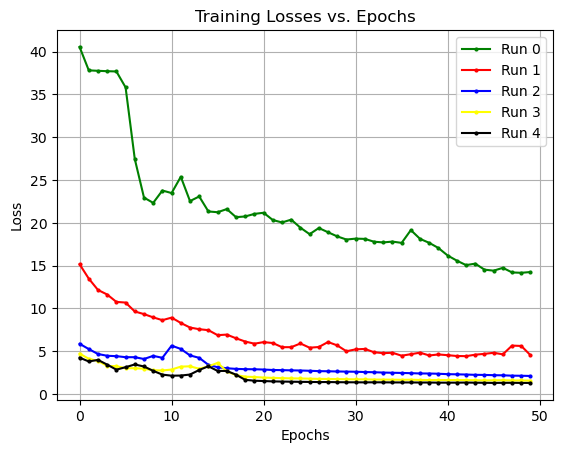

In [16]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, all_loss_values[0:50], marker='o', markersize=2, label='Run 0', color='green')
plt.plot(epochs_plot, all_loss_values[50:100], marker='o', markersize=2, label='Run 1', color='red')
plt.plot(epochs_plot, all_loss_values[100:150], marker='o', markersize=2, label='Run 2', color='blue')
plt.plot(epochs_plot, all_loss_values[150:200], marker='o', markersize=2, label='Run 3', color='yellow')
plt.plot(epochs_plot, all_loss_values[200:250], marker='o', markersize=2, label='Run 4', color='black')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

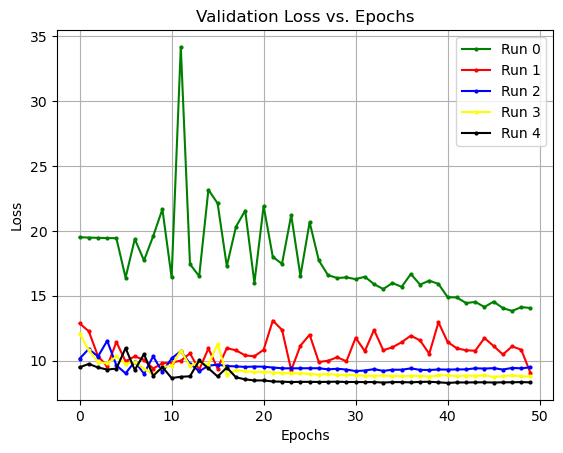

In [17]:
epochs_plot = list(range(0,num_epochs))

# Plot validation losses against epochs
plt.plot(epochs_plot, all_val_loss_values[0:50], marker='o', markersize=2, label='Run 0', color='green')
plt.plot(epochs_plot, all_val_loss_values[50:100], marker='o', markersize=2, label='Run 1', color='red')
plt.plot(epochs_plot, all_val_loss_values[100:150], marker='o', markersize=2, label='Run 2', color='blue')
plt.plot(epochs_plot, all_val_loss_values[150:200], marker='o', markersize=2, label='Run 3', color='yellow')
plt.plot(epochs_plot, all_val_loss_values[200:250], marker='o', markersize=2, label='Run 4', color='black')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing NN

In [18]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

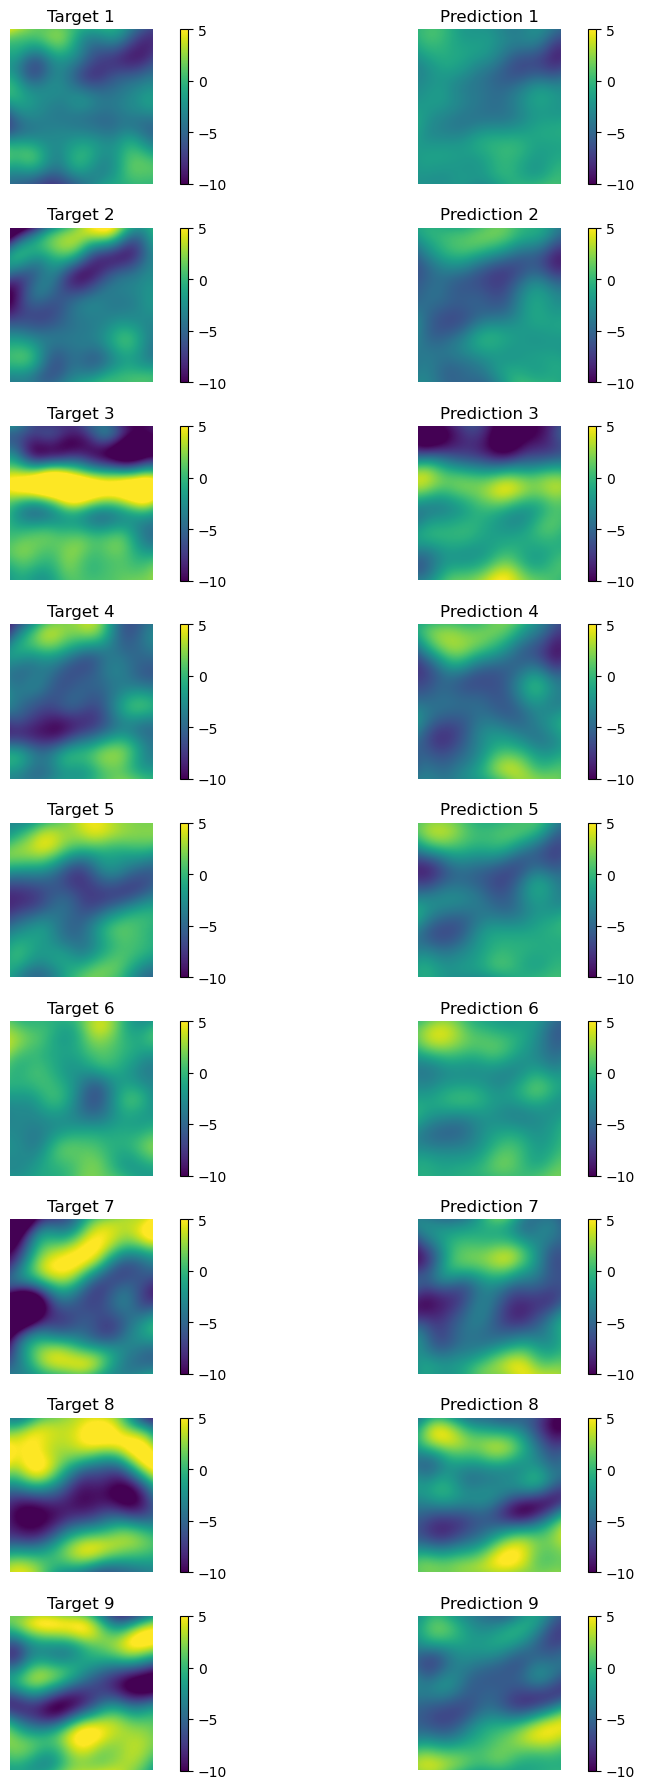

In [19]:
def plot_predictions_vs_targets(predictions, targets, num_samples=9):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=9)  # Change num_samples as needed
